# Cinema LSTM

----

Starting from Panda and Numpy

In [23]:
# pandas as pd
try:
    import pandas as pd
    print('Pandas already installed, only imported')
except:
    !pip install pandas
    import pandas as pd
    print('Pandas was not installed, installed and imported')
    
# numpy as np
try:
    import numpy as np
    print('NumPy already installed, only imported')
except:
    !pip install numpy
    import numpy as np
    print('NumPy was not installed, installed and imported')
    
# pyplot as plt
try:
    import matplotlib.pyplot as plt
    print('PyPlot already installed, only imported')
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    print('PyPlot was not installed, installed and imported')    

Pandas already installed, only imported
NumPy already installed, only imported
PyPlot already installed, only imported


In [24]:
cinema = pd.read_csv('../data/cinema.csv', sep=';', low_memory=False)

# Mapping dictionary for translating Dutch day names to English
dutch_to_english = {
    'Zondag': 'Sunday',
    'maandag': 'Monday',
    'dinsdag': 'Tuesday',
    'woensdag': 'Wednesday',
    'donderdag': 'Thursday',
    'vrijdag': 'Friday',
    'zaterdag': 'Saturday'
}

# Translate Dutch day names to English
cinema['Day'] = cinema['Day'].map(dutch_to_english)

# Convert the "Date" column to datetime
cinema['Date'] = pd.to_datetime(cinema['Date'], format='%d/%m/%Y')

# Drop rows with missing values in the "Visitor" column
cinema = cinema.dropna(subset=['Visitor'])

# Convert the "Visitor" column to numeric to check for non-numeric values
cinema['Visitor'] = pd.to_numeric(cinema['Visitor'], errors='coerce')

# Drop rows with non-numeric values in the "Visitor" column
cinema = cinema.dropna(subset=['Visitor'])

# Convert the "Visitor" column to integer
cinema['Visitor'] = cinema['Visitor'].astype(int)

# Extract each column into separate variables
day_categorical = cinema['Day'].astype('category')
date = cinema['Date']
visitor = cinema['Visitor']

In [25]:
cinema.head()

,Day,Date,Visitor
0,Sunday,2023-01-01,484
1,Monday,2023-01-02,832
2,Tuesday,2023-01-03,872
3,Wednesday,2023-01-04,1003
4,Thursday,2023-01-05,851


In [26]:
cinema.dtypes

Day                object
Date       datetime64[ns]
Visitor             int32
dtype: object

In [27]:
pd.options.mode.chained_assignment = None  # default='warn'

# Summary statistics for visitor counts
visitor_summary = cinema['Visitor'].describe()

# Print the summary statistics
print(visitor_summary)

count     428.000000
mean      497.616822
std       269.279597
min       107.000000
25%       304.500000
50%       406.500000
75%       653.750000
max      1437.000000
Name: Visitor, dtype: float64


In [28]:
cinema.head()

,Day,Date,Visitor
0,Sunday,2023-01-01,484
1,Monday,2023-01-02,832
2,Tuesday,2023-01-03,872
3,Wednesday,2023-01-04,1003
4,Thursday,2023-01-05,851


LSTM Model Test Loss: 0.030201932415366173
3/3 [==============================] - 1s 4ms/step


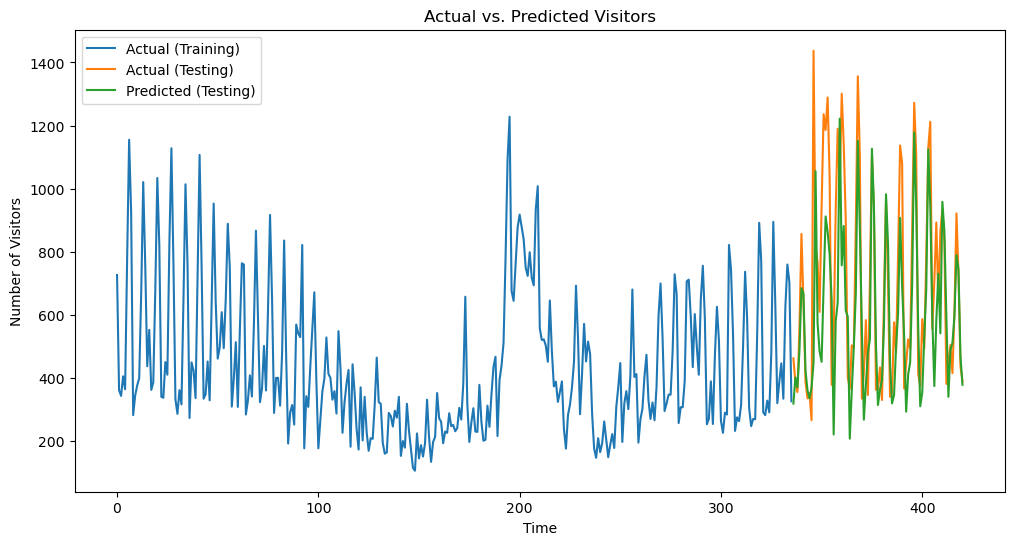

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(cinema['Visitor'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual values for plotting
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted visitor numbers
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the baseline prediction using the average of actual values
baseline_prediction = np.mean(actual_values)
baseline_predictions = np.full_like(actual_values, baseline_prediction)

# Evaluate the baseline model using Mean Squared Error (MSE)
baseline_mse = mean_squared_error(actual_values, baseline_predictions)
print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")

# Calculate Root Mean Squared Error (RMSE) for the baseline model
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE) for the baseline model
baseline_mape = np.mean(np.abs((actual_values - baseline_predictions) / actual_values)) * 100
print(f"Baseline Mean Absolute Percentage Error (MAPE): {baseline_mape}%")

# Calculate R-squared (coefficient of determination) for the baseline model
baseline_r2 = r2_score(actual_values, baseline_predictions)
print(f"Baseline R-squared (Coefficient of Determination): {baseline_r2}")


Baseline Mean Squared Error (MSE): 98437.46934256054
Baseline Root Mean Squared Error (RMSE): 313.7474610934095
Minimum value: 267.0
Maximum value: 1437.0
Range: 1170.0
Baseline Mean Absolute Percentage Error (MAPE): 46.96332267730152%
Baseline R-squared (Coefficient of Determination): 0.0


In [51]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 53424.19847417748
Root Mean Squared Error (RMSE): 231.13675275511136
Minimum value: 267.0
Maximum value: 1437.0
Range: 1170.0
Mean Absolute Percentage Error (MAPE): 23.787139130323528%
R-squared (Coefficient of Determination): 0.4572778147286347


Import the data:

In [32]:
wifi_data = pd.read_csv("../data/wifi_data.csv", low_memory=False)

In [33]:
wifi_data.head()

,Date Time,Date Time(RAW),Total Online Devices,Total Online Devices(RAW),Speed Bad,Speed Bad(RAW),Speed Good,Speed Good(RAW),Speed Better,Speed Better(RAW),...,Experience Bad,Experience Bad(RAW),Experience Good,Experience Good(RAW),Experience Better,Experience Better(RAW),Downtime,Downtime(RAW),Coverage,Coverage(RAW)
0,1-9-2023 00:00:00 - 01:00:00,45169.95833,61 #,60.9000,"0,57 #",0.5667,"9,88 #",9.8833,50 #,50.4500,...,"0,62 #",0.6167,"0,17 #",0.1667,62 #,62.3667,0%,0.0,100%,10000.0
1,1-9-2023 01:00:00 - 02:00:00,45170.00000,58 #,58.3500,"0,85 #",0.8500,11 #,10.7833,47 #,46.7167,...,"0,55 #",0.5500,"0,15 #",0.1500,58 #,58.4500,0%,0.0,100%,10000.0
2,1-9-2023 02:00:00 - 03:00:00,45170.04167,57 #,57.3833,"0,47 #",0.4667,"9,73 #",9.7333,47 #,47.1833,...,"0,38 #",0.3833,"0,17 #",0.1667,57 #,56.8333,0%,0.0,100%,10000.0
3,1-9-2023 03:00:00 - 04:00:00,45170.08333,57 #,57.4000,"0,52 #",0.5167,10 #,10.4000,46 #,46.4833,...,"0,15 #",0.1500,0 #,0.0000,57 #,57.3667,0%,0.0,100%,10000.0
4,1-9-2023 04:00:00 - 05:00:00,45170.12500,57 #,57.1333,"0,30 #",0.3000,10 #,10.4833,46 #,46.3500,...,"0,42 #",0.4167,"0,17 #",0.1667,57 #,56.9667,0%,0.0,100%,10000.0


Use only the necessary columns from our dataset:

In [34]:
wifi_data = wifi_data[['Date Time', 'Total Online Devices']]
wifi_data.head()

,Date Time,Total Online Devices
0,1-9-2023 00:00:00 - 01:00:00,61 #
1,1-9-2023 01:00:00 - 02:00:00,58 #
2,1-9-2023 02:00:00 - 03:00:00,57 #
3,1-9-2023 03:00:00 - 04:00:00,57 #
4,1-9-2023 04:00:00 - 05:00:00,57 #


Ok, now let's check if there's any missing values

In [35]:
wifi_data.isnull().sum()

Date Time                0
Total Online Devices    52
dtype: int64

Drop the null values from the dataset:

In [36]:
wifi_data = wifi_data.dropna()
wifi_data.isna().sum()

Date Time               0
Total Online Devices    0
dtype: int64

Convert the value of the total number of the devices to an integer:

In [37]:
wifi_data['Total Online Devices'] = wifi_data['Total Online Devices'].str.replace('#','').astype(int)

Have a look of the chnaged data and check their data type:

In [38]:
wifi_data.head()

,Date Time,Total Online Devices
0,1-9-2023 00:00:00 - 01:00:00,61
1,1-9-2023 01:00:00 - 02:00:00,58
2,1-9-2023 02:00:00 - 03:00:00,57
3,1-9-2023 03:00:00 - 04:00:00,57
4,1-9-2023 04:00:00 - 05:00:00,57


Group all the all data based on the date. Add the total, mean, max and min of the devices conneted on a specific date:

In [39]:
dt = wifi_data['Date Time'].str.split(' ').str[0] 
devices = wifi_data['Total Online Devices']

new_data_wifi_df = pd.DataFrame({'datetime': dt, 'totaldevices': devices})

new_data_wifi_df = new_data_wifi_df[new_data_wifi_df['datetime'] != 'Averages']

new_data_wifi_df['datetime'] = pd.to_datetime(new_data_wifi_df['datetime'], format='%d-%m-%Y')

grouped_data = new_data_wifi_df.groupby('datetime').agg({'totaldevices': ['mean', 'max', 'min']})
grouped_data.columns = grouped_data.columns.map(''.join)

total_devices_sum = new_data_wifi_df.groupby('datetime')['totaldevices'].sum()

sorted_grouped_wifi_data = pd.merge(grouped_data, total_devices_sum, left_index=True, right_index=True)

sorted_grouped_wifi_data.rename(columns={'totaldevices': 'totaldevicessum'}, inplace=True)

sorted_grouped_wifi_data = sorted_grouped_wifi_data.sort_index()

sorted_grouped_wifi_data.head()

,totaldevicesmean,totaldevicesmax,totaldevicesmin,totaldevicessum
datetime,,,,
2023-09-01,104.125000,195,57,2499
2023-09-02,63.625000,72,57,1527
2023-09-03,62.833333,72,58,1508
2023-09-04,162.583333,387,57,3902
2023-09-05,162.583333,377,52,3902


In [40]:
wifi = sorted_grouped_wifi_data.copy()

LSTM Model Test Loss: 0.008709598332643509
2/2 [==============================] - 1s 11ms/step


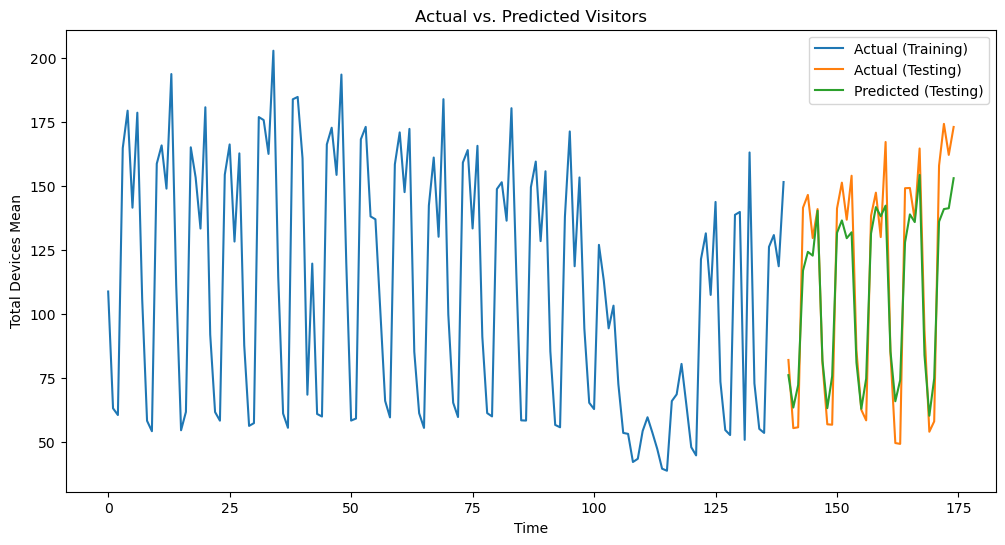

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(wifi['totaldevicesmean'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual values for plotting
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted visitor numbers
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Mean')
plt.legend()
plt.show()

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 235.20651335172843
Root Mean Squared Error (RMSE): 15.336443960440388
Minimum value: 49.083333333333336
Maximum value: 174.29166666666666
Range: 125.20833333333331
Mean Absolute Percentage Error (MAPE): 13.075539312218663%
R-squared (Coefficient of Determination): 0.8777197654003202


Baseline

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the baseline prediction using the average of actual values
baseline_prediction = np.mean(actual_values)
baseline_predictions = np.full_like(actual_values, baseline_prediction)

# Evaluate the baseline model using Mean Squared Error (MSE)
baseline_mse = mean_squared_error(actual_values, baseline_predictions)
print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")

# Calculate Root Mean Squared Error (RMSE) for the baseline model
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE) for the baseline model
baseline_mape = np.mean(np.abs((actual_values - baseline_predictions) / actual_values)) * 100
print(f"Baseline Mean Absolute Percentage Error (MAPE): {baseline_mape}%")

# Calculate R-squared (coefficient of determination) for the baseline model
baseline_r2 = r2_score(actual_values, baseline_predictions)
print(f"Baseline R-squared (Coefficient of Determination): {baseline_r2}")


Baseline Mean Squared Error (MSE): 1923.5039425770308
Baseline Root Mean Squared Error (RMSE): 43.85776946650423
Minimum value: 49.083333333333336
Maximum value: 174.29166666666666
Range: 125.20833333333331
Baseline Mean Absolute Percentage Error (MAPE): 48.372850789499616%
Baseline R-squared (Coefficient of Determination): 0.0
